# Additional (Alternative) Analysis of music-chord-oddball: ERP Analysis

In [1]:
import mne
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

In [2]:
def get_epochs_from_events(data, event_str, min_reaction_s=None):
    """
    Epoch the given data based on the event_str. Exclude to fast reactions if we are in the case of a deviant event.

    Args:
        data (mne.raw): EEG Data to epoch
        event_str (string): String to determine for which event to epoch to
        min_reaction_s (float, optional): Time in seconds for the minimal reaction time at deviant events. Defaults to None.

    Returns:
        mne.Epoch: Epoch of the data for the given event
    """
    evts, evts_dict = mne.events_from_annotations(data)

    # Identify deviant events
    deviant_keys = [e for e in evts_dict.keys() if e.endswith(event_str)]
    correct_keys = [e for e in evts_dict.keys() if "STATUS:Correct - " in e]

    # Construct a dictionary of deviant events
    evts_dict_stim = {}
    for key in deviant_keys:
        evts_dict_stim[key] = evts_dict[key]

    data.info.normalize_proj()
    # Reject threshold
    reject = dict(eeg=0.0004)  # in V

    epochs = mne.Epochs(data, evts, evts_dict_stim, tmin=-0.4, tmax=1.6, baseline=(-0.4, 0), preload=True, reject=reject)

    if min_reaction_s:
        # Reconstruct which epochs where droped
        rejected_idx = []
        epoch_idx = 0

        for i, log in enumerate(epochs.drop_log):
            if len(log) == 0:
                epoch_idx += 1
            elif not log[0] == "IGNORED":
                rejected_idx.append(epoch_idx)
                epoch_idx += 1


        # Get the Labels, which where used for epoching
        d_evts = evts[evts[:, 2] == evts_dict_stim[deviant_keys[0]]]
        
        for key in deviant_keys[1:]:            
            d_evts = np.concatenate((d_evts, evts[evts[:, 2] == evts_dict_stim[key]]))
        
        # Sort events by time, to fit indexes to the indices in epochs
        d_evts = sorted(d_evts, key=lambda x: x[0])

        reaction_times = []
        i = 0
        for epoch_idx, d_evt in enumerate(d_evts):
            if not epoch_idx in rejected_idx:
                # Find the closest "Correct -" event
                c_evts = evts[np.isin(evts[:, 2], [evts_dict[key] for key in correct_keys]) & (evts[:, 0] > d_evt[0])]
                if len(c_evts) > 0:
                    # Calculate the reaction time
                    reaction_time = (c_evts[0][0] - d_evt[0]) / data.info['sfreq']  # convert to ms
                    reaction_times.append((reaction_time, key, i))
                    i += 1
        
        #Filter epochs based on reaction time
        valid_epochs = [i for (rt, _, i) in reaction_times if min_reaction_s <= rt]
        print(f"Filtered {len(valid_epochs)} epochs out of {len(epochs)} based on reaction time threshold")
        epochs = epochs[valid_epochs]

    return epochs

In [3]:
fif_path = './data/fifs'

fif_files = [f for f in os.listdir(fif_path) if f.endswith('.fif')]

all_epochs = []

for fif_file in fif_files:
    # extract sub id (processed_{id}_raw.fif)
    sub_id = int(fif_file.split('_')[1])
    raw = mne.io.read_raw_fif(os.path.join(fif_path, fif_file), preload=True)
    
    standard_epochs = get_epochs_from_events(raw, '_S')
    exemplar_epochs = get_epochs_from_events(raw, '_deviantEcorrect_E', min_reaction_s=0.2)
    function_epochs = get_epochs_from_events(raw, '_deviantFcorrect_F', min_reaction_s=0.2)
    
    all_epochs.append({'sub_id': sub_id, 'standard': standard_epochs, 'exemplar': exemplar_epochs, 'function': function_epochs})

Opening raw data file ./data/fifs/processed_015_raw.fif...


    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 324223 =      0.000 ...  2532.992 secs
Ready.
Reading 0 ... 324223  =      0.000 ...  2532.992 secs...
Used Annotations descriptions: ['STATUS:16128', 'STATUS:16368', 'STATUS:Correct - Exemplar!', 'STATUS:Correct - Function!', 'STATUS:Incorrect - Standard!', 'STATUS:boundary', 'STATUS:five6_S', 'STATUS:five6_Sincorrect', 'STATUS:five6_deviantE', 'STATUS:five6_deviantEcorrect_E', 'STATUS:five6_deviantF', 'STATUS:five6_deviantFcorrect_F', 'STATUS:fiveRoot_S', 'STATUS:fiveRoot_Sincorrect', 'STATUS:fiveRoot_deviantE', 'STATUS:fiveRoot_deviantEcorrect_E', 'STATUS:fiveRoot_deviantF', 'STATUS:fiveRoot_deviantFcorrect_F', 'STATUS:four6_S', 'STATUS:four6_Sincorrect', 'STATUS:four6_deviantE', 'STATUS:four6_deviantEcorrect_E', 'STATUS:four6_deviantF', 'STATUS:four6_deviantFcorrect_F', 'STATUS:fourRoot_S', 'STATUS:fourRoot_Sincorrect', 'STATUS:fourRoot_deviantE', 'STATUS:fourRoot_deviantEcorrect_

# Manual Check of Epochs

Using matplotlib as 2D backend.


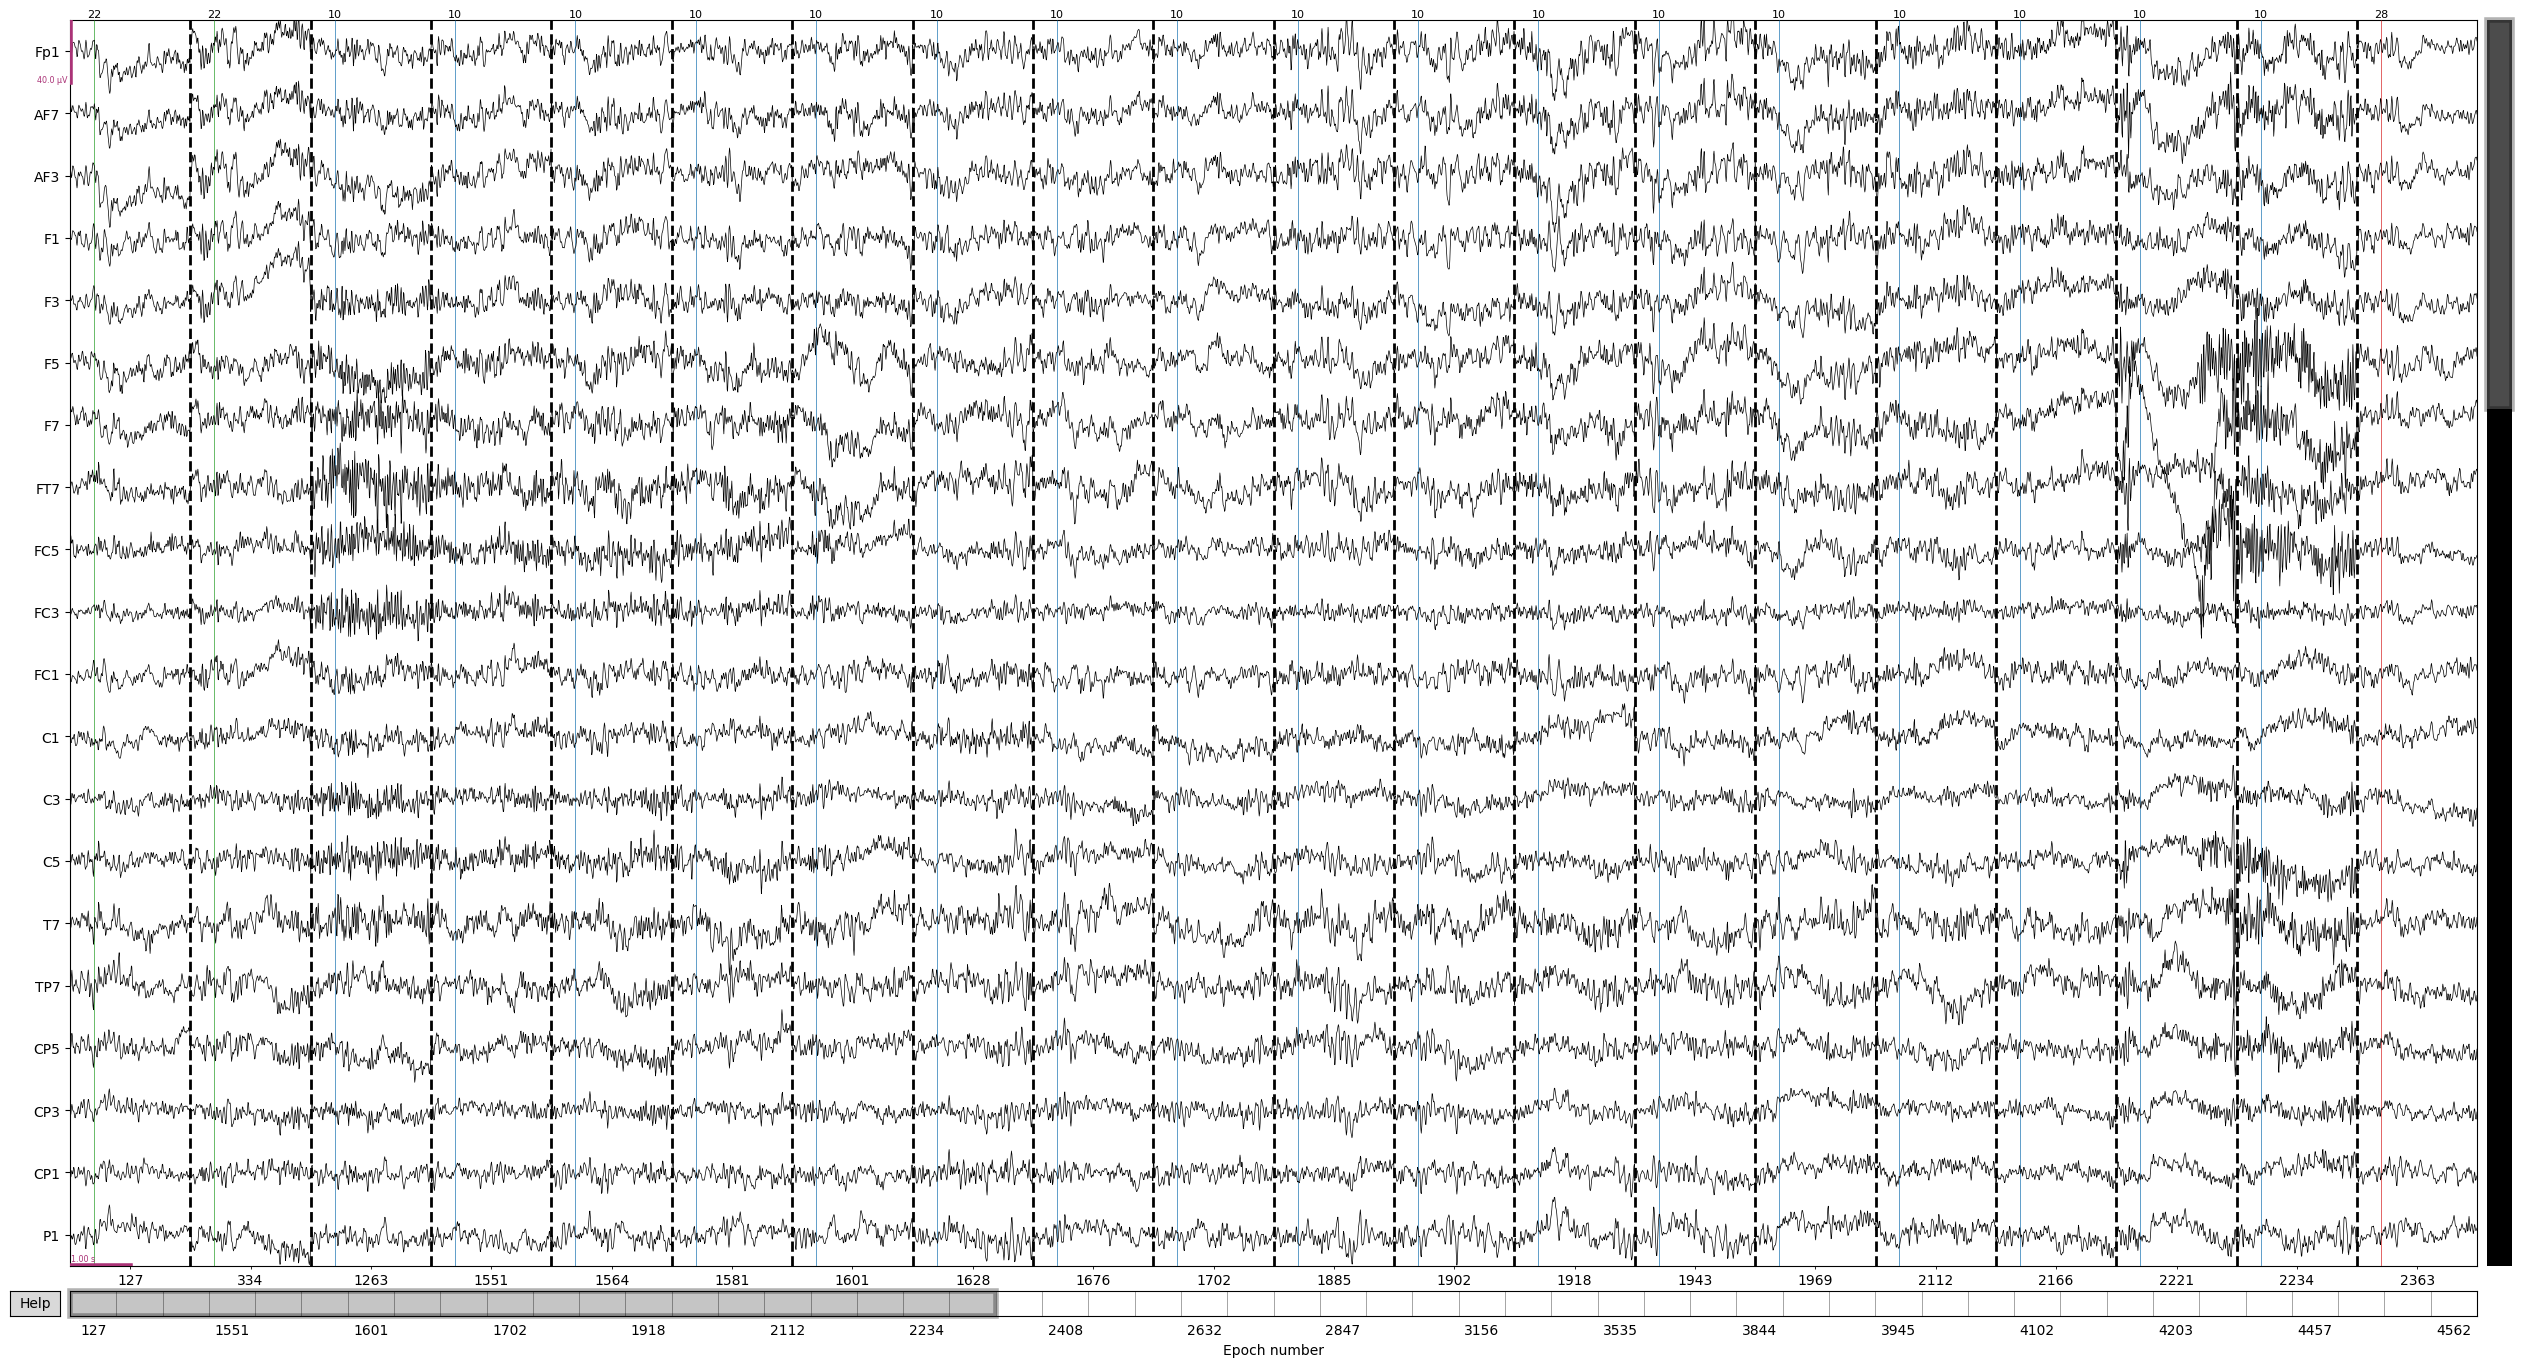

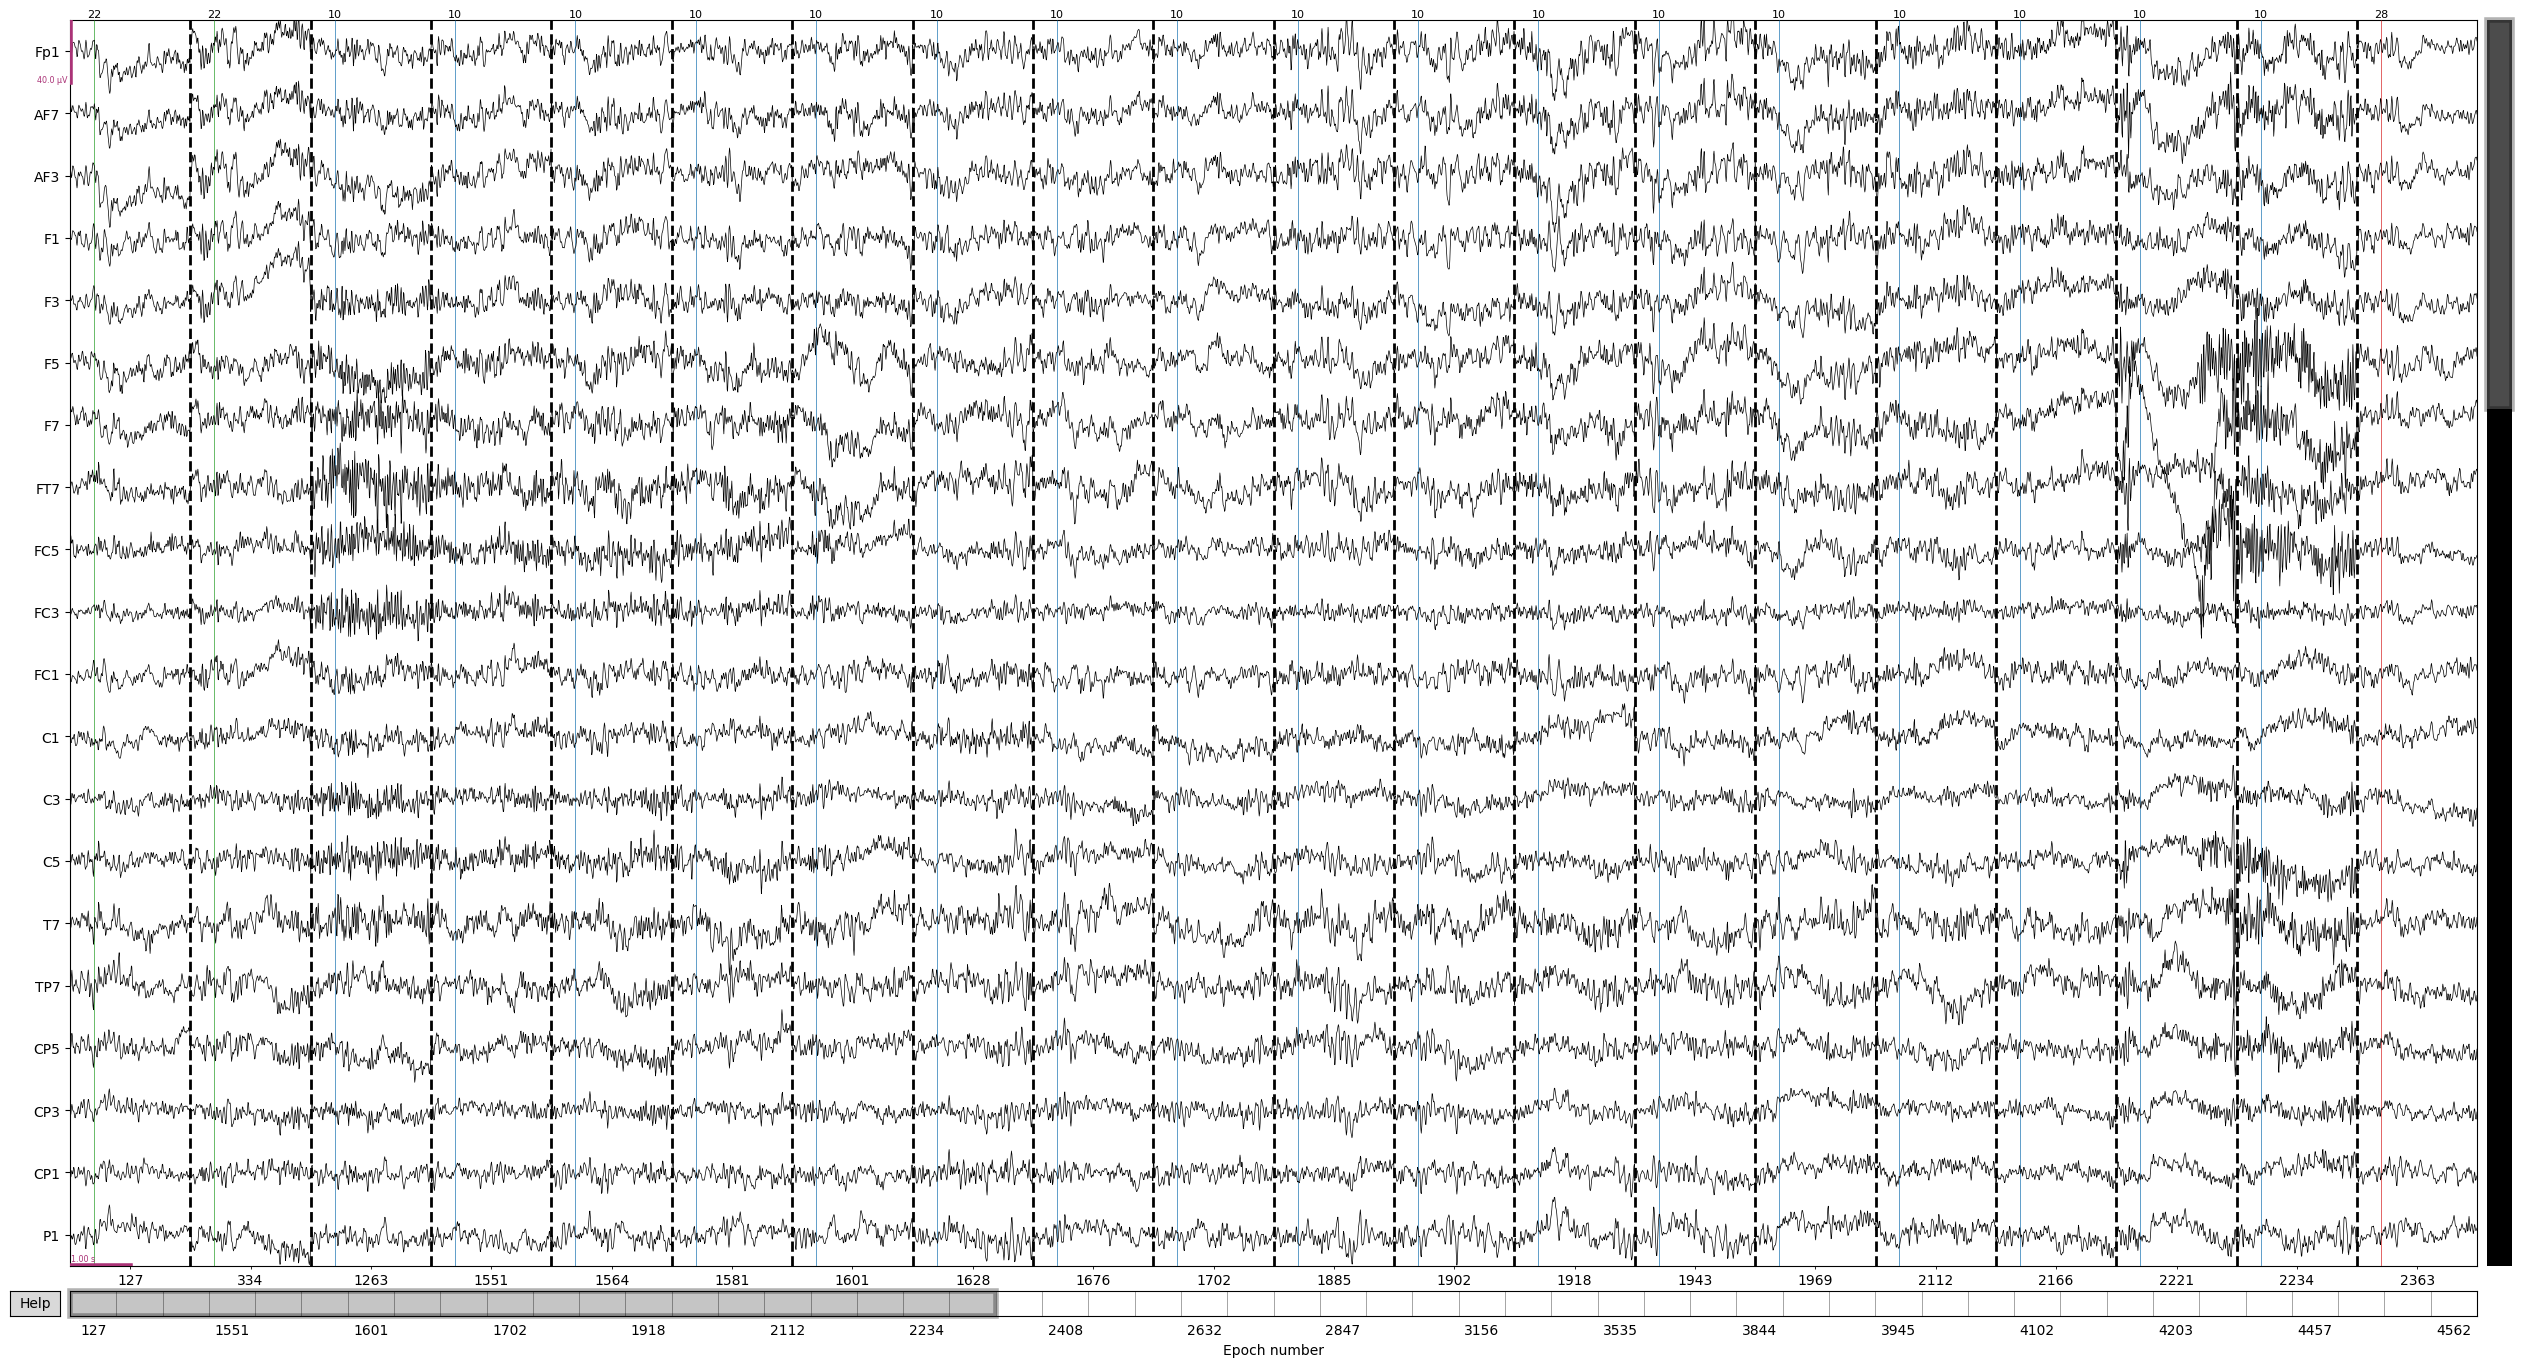

In [4]:
all_epochs[0]['exemplar'].plot(events=True)

# Average ERPs

In [5]:
average_erps = []
for subject_epochs in all_epochs:
    sub_id = subject_epochs['sub_id']
    for condition in ['standard', 'exemplar', 'function']:
        avg_erp = subject_epochs[condition].average()
        average_erps.append({'sub_id': sub_id, 'condition': condition, 'avg_erp': avg_erp})

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

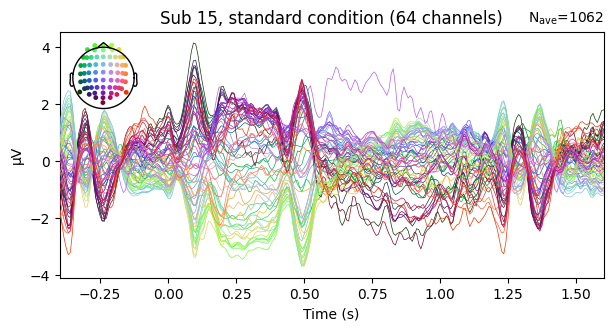

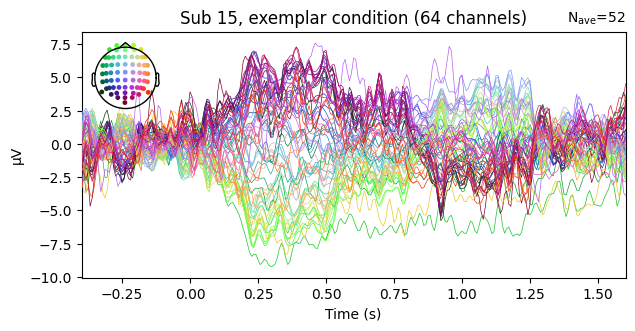

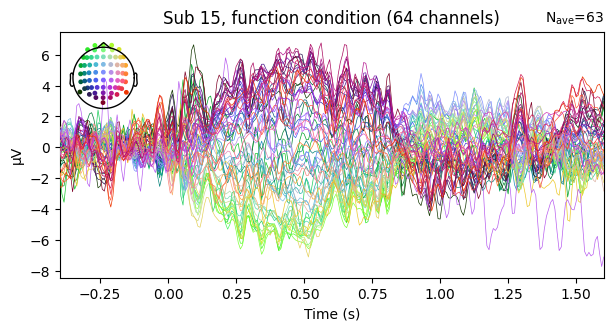

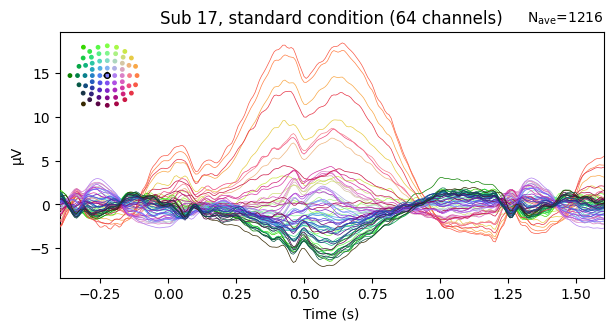

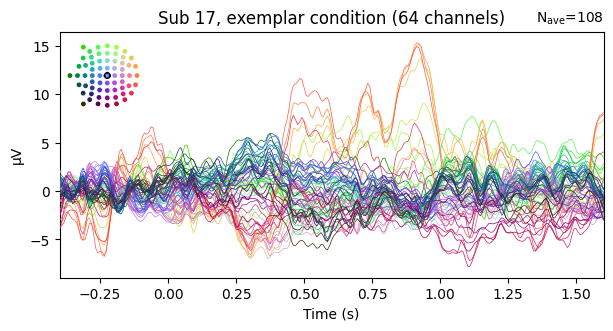

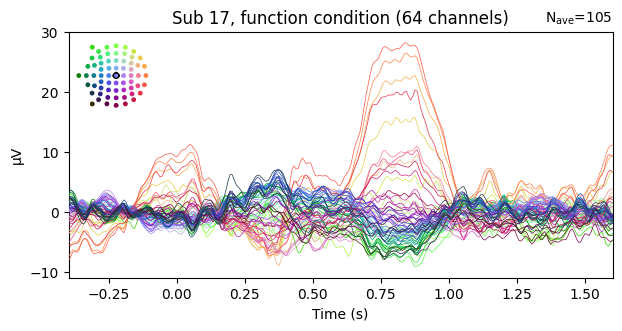

In [6]:
for avg in average_erps[:6]:
    avg['avg_erp'].plot(titles=f"Sub {avg['sub_id']}, {avg['condition']} condition")

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


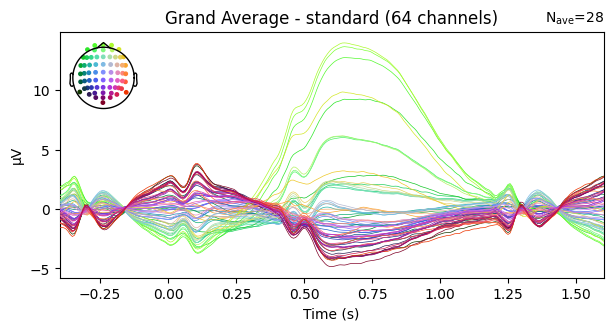

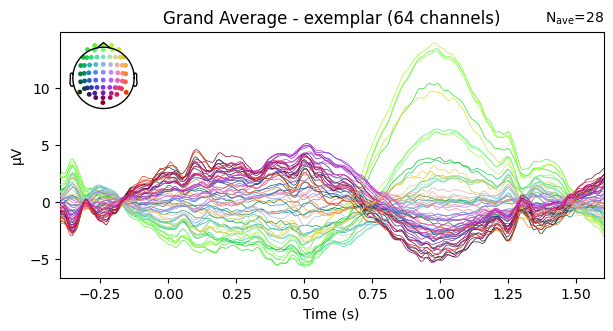

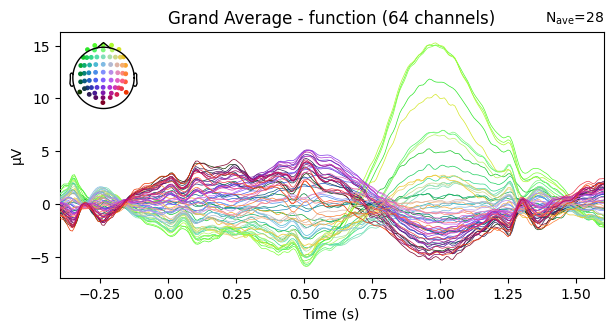

In [7]:
grand_averages = {condition: mne.grand_average([ep['avg_erp'] for ep in average_erps if ep['condition'] == condition])
                  for condition in ['standard', 'exemplar', 'function']}
for condition, grand_avg in grand_averages.items():
    grand_avg.plot(titles=f"Grand Average - {condition}")

# Focused Analysis

We will proceed by focusing on the relevant channels based on our ICA results for exemplar and function deviants. We will then identify relevant ERP components.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

/tmp/ipykernel_13462/607910395.py:26: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  temp_grand_avg = grand_avg.copy().crop(*time_window).pick_channels(channels_of_interest)
/tmp/ipykernel_13462/607910395.py:26: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  temp_grand_avg = grand_avg.copy().crop(*time_window).pick_channels(channels_of_interest)
/tmp/ipykernel_13462/607910395.py:26: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the re

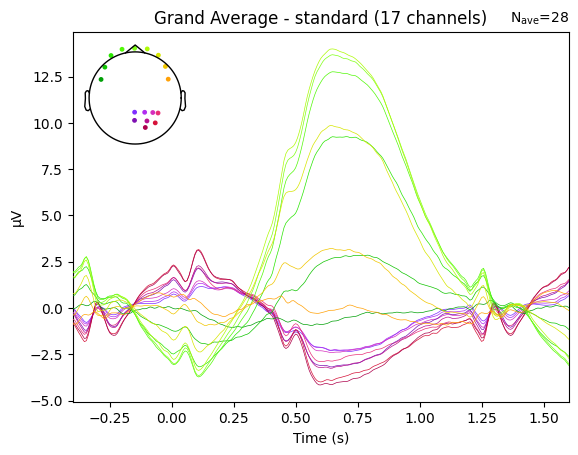

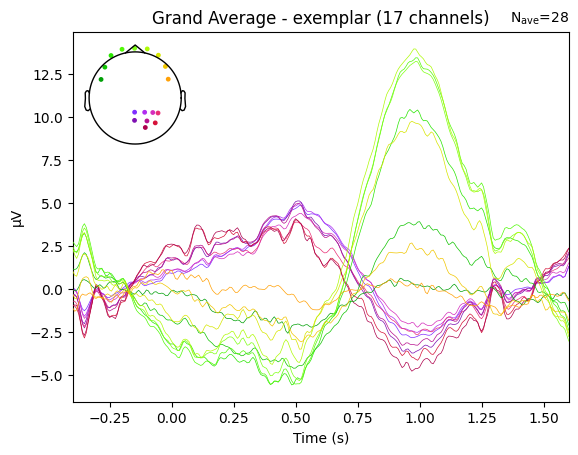

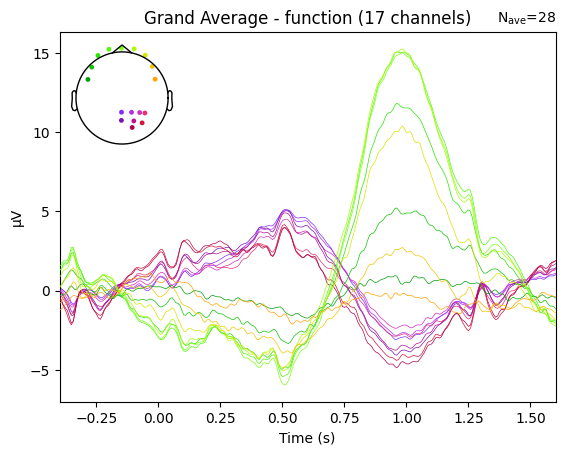

In [8]:
# determine the channels of interest based on previous ICA plots of exemplar and function
# high voltage areas are similar for exemplar and function (These are the channels Pz to O2), low voltage areas are on the left front for exemplar and on the right front for function (therefor we will regard all frontal channels as well)
channels_of_interest = ['Pz', 'P2', 'P4', 'P6', 'POz', 'PO4', 'PO8', 'O2', 'FT7', 'F7', 'AF7', 'Fp1', 'Fpz', 'Fp2', 'AF8', 'F8', 'FT8']

conditions = ['standard', 'exemplar', 'function']
erp_measures = []


evoked_dict = {condition: [] for condition in conditions}
for subject in all_epochs:
    for condition in conditions:
        evoked = subject[condition].average()
        evoked_dict[condition].append(evoked)

# calc grand averages for each condition
grand_averages = {}
for condition in conditions:
    grand_averages[condition] = mne.grand_average(evoked_dict[condition])

# focus on time frame of specific ERP component
time_window = (0.40, 0.55)  # TBD: adjust?

# calc mean amplitude and peak latency within the time window for each condition
for condition, grand_avg in grand_averages.items():
    # crop the grand average to time window and pick channels of interest
    temp_grand_avg = grand_avg.copy().crop(*time_window).pick_channels(channels_of_interest)
    
    # calc mean amplitude for each channel
    mean_amplitudes = temp_grand_avg.data.mean(axis=1)
    
    # calc peak latency for each channel
    peak_times = temp_grand_avg.get_peak(ch_type='eeg', tmin=time_window[0], tmax=time_window[1], mode='pos')[1]
    
    erp_measures.append({
        'condition': condition,
        'mean_amplitudes': mean_amplitudes,
        'peak_latencies': peak_times
    })

for measure in erp_measures:
    print(f"Condition: {measure['condition']}")
    print("Channels: ", channels_of_interest)
    print("Mean Amplitudes (µV): ", measure['mean_amplitudes'])
    print("Peak Latencies (s): ", measure['peak_latencies'])
    print('\n')

for condition, grand_avg in grand_averages.items():
    fig, ax = plt.subplots()
    grand_avg.plot(picks=channels_of_interest, axes=ax, titles=f"Grand Average - {condition}", spatial_colors=True)
    plt.show()


# Identify relevant ERP Components
Finally we will mark the relevant ERP components based on the paper to ensure our results match up with the paper. The paper proposes the components N2c and P3b as the relevant ERP components which are most discriminative for participants with more improvisation experience. Following the results of the AUC curve and the most discriminative channels, we expect to see the P3b component, while the N2c component might not be as prominent. We see the P3b component at the end of the possible range (around 500 ms)

Background Info:
N2c is the classification N2, elicited when classification of disparate stimuli is needed. N2 is a negative deflection peaking at about 200 msec after presentation of stimulus. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3016705/)
P3b: P3b is a positive-going amplitude (usually relative to a reference behind the ear or the average of two such references). For auditory stimuli, the latency range is 250-500 msec for most adult subjects between 20 and 70 years of age. Generally speaking, improbable events will elicit a P3b, and the less probable the event, the larger the P3b. (https://en.wikipedia.org/wiki/P3b).

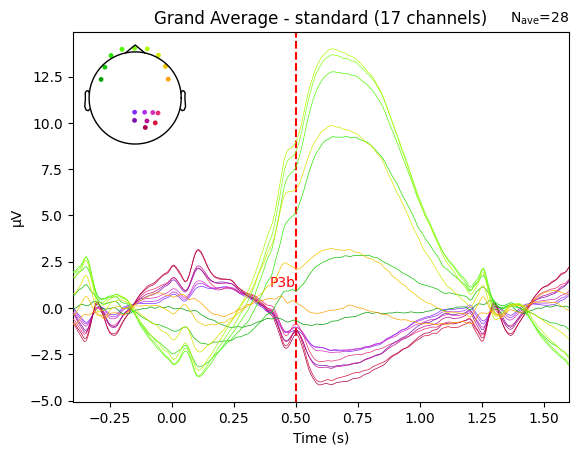

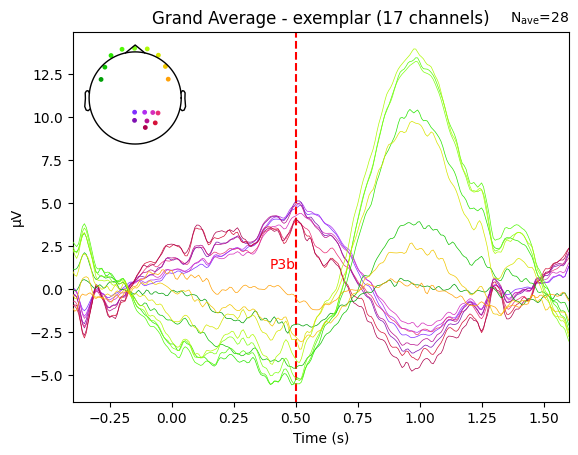

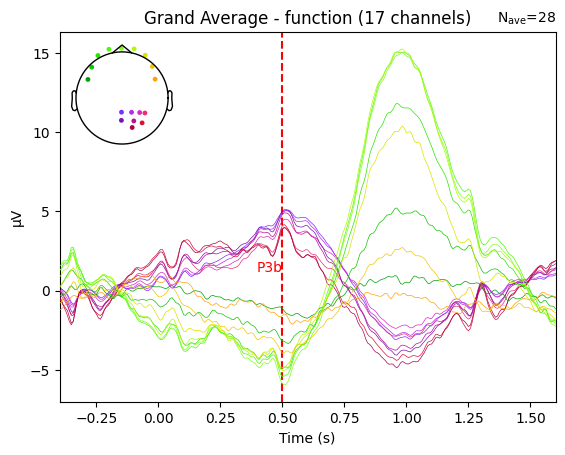

In [11]:
# mark the erp components N2c and P3b for each condition grand avg plot
for condition, grand_avg in grand_averages.items():
    fig, ax = plt.subplots()
    ax.axvline(0.5, color='r', linestyle='--')  # P3b
    ax.text(0.5, ax.get_ylim()[1], 'P3b', color='r', verticalalignment='bottom', horizontalalignment='right')
    grand_avg.plot(picks=channels_of_interest, axes=ax, titles=f"Grand Average - {condition}", spatial_colors=True)
    #ax.axvline(0.3, color='r', linestyle='--')  # N2c Not really detectable
    plt.show()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

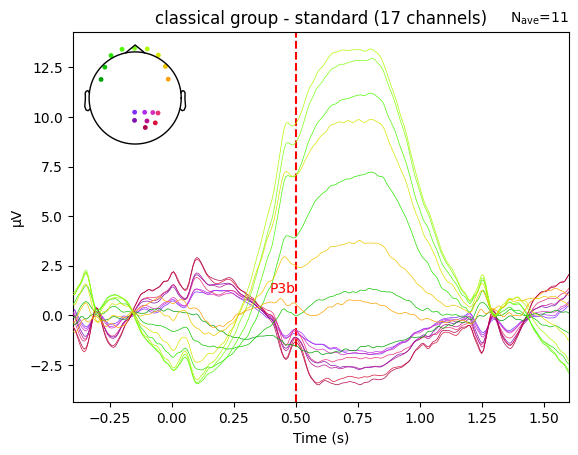

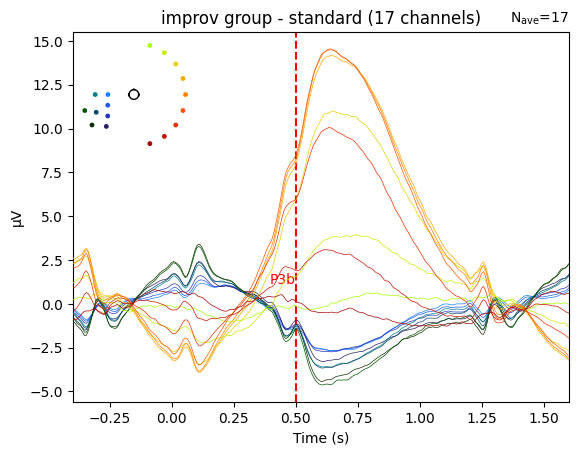

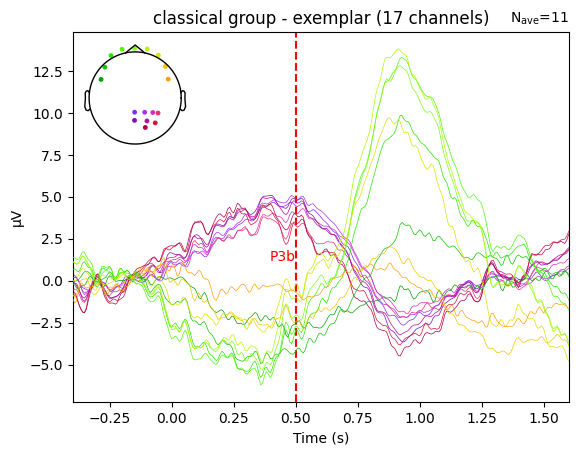

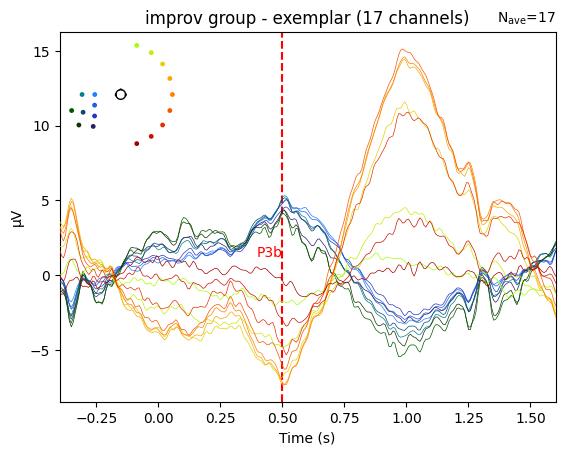

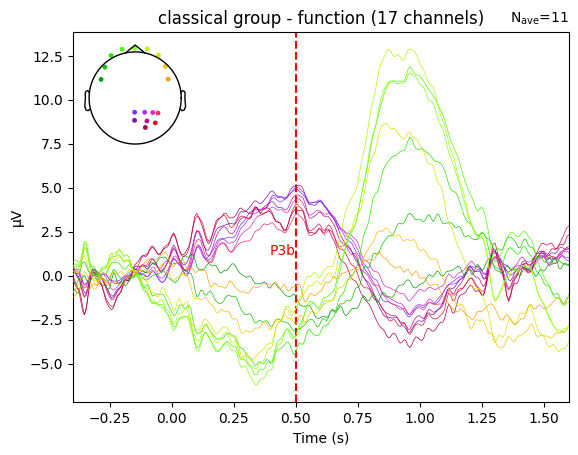

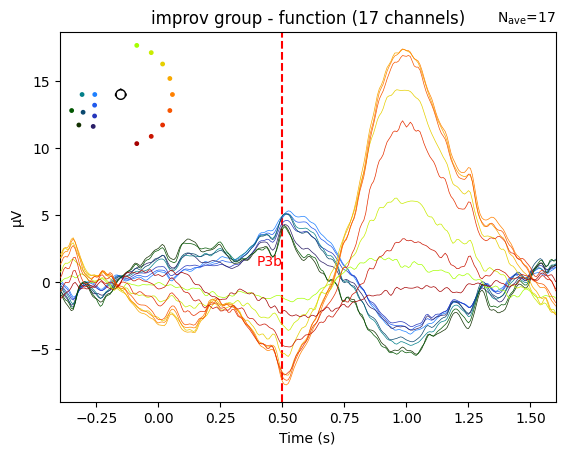

In [22]:
# compare discriminability of P3b for improvisation group and classical group for each condition. (data is taken from questionnaire)
classical_group_ids = [2, 3, 4, 8, 10, 11, 15, 17, 22, 23, 24, 27, 29, 33, 36] # class = classical
improv_group_ids = [5, 6, 7, 9, 12, 13, 14, 16, 18, 19, 20, 21, 25, 26, 28, 30, 31, 32, 34, 35, 37, 38, 39, 40]

# filter all_epochs for classical and improv group subjects by id
classical_group_epochs = [ep for ep in all_epochs if ep['sub_id'] in classical_group_ids]
improv_group_epochs = [ep for ep in all_epochs if ep['sub_id'] in improv_group_ids]

evoked_dict_class = {condition: [] for condition in conditions}

for subject in classical_group_epochs:
    for condition in conditions:
        evoked = subject[condition].average()
        evoked_dict_class[condition].append(evoked)

# calc grand averages for each condition for class group
grand_averages_class = {}
for condition in conditions:
    grand_averages_class[condition] = mne.grand_average(evoked_dict_class[condition])


evoked_dict_improv = {condition: [] for condition in conditions}

for subject in improv_group_epochs:
    for condition in conditions:
        evoked = subject[condition].average()
        evoked_dict_improv[condition].append(evoked)

# calc grand averages for each condition for improv group
grand_averages_improv = {}
for condition in conditions:
    grand_averages_improv[condition] = mne.grand_average(evoked_dict_improv[condition])


for (condition, grand_avg_class), (_, grand_averages_improv) in zip(grand_averages_class.items(), grand_averages_improv.items()):
    fig, ax = plt.subplots()
    ax.axvline(0.5, color='r', linestyle='--')  # P3b
    ax.text(0.5, ax.get_ylim()[1], 'P3b', color='r', verticalalignment='bottom', horizontalalignment='right')
    grand_avg_class.plot(picks=channels_of_interest, axes=ax, titles=f"classical group - {condition}", spatial_colors=True)
    plt.show()
    fig, ax = plt.subplots()
    ax.axvline(0.5, color='r', linestyle='--')  # P3b
    ax.text(0.5, ax.get_ylim()[1], 'P3b', color='r', verticalalignment='bottom', horizontalalignment='right')
    grand_averages_improv.plot(picks=channels_of_interest, axes=ax, titles=f"improv group - {condition}", spatial_colors=True)
    plt.show()

# Thoughts

- We can clearly see that although our P3b component is at the end of the accepted range, it is only present in the deviants and not in the standards. This is a good sign as it matches with our understanding of the P3b component as a response to improbable events.
- When looking at the P3b component, we can see that the P3b component seems more discriminable for the improvisation group than the classical group, as supposed by the paper.